# Import Necessary Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import io

# Utils

Helps to compute the error for that batch

In [2]:
def get_error( scores , labels ):

    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    
    return 1-num_matches.float()/bs 

Note: My computer has no gpu, so i will run on cpu, but the gpu code is included

In [3]:
device= torch.device("cpu")
# To run on gpu, comment the above line and uncomment the below line
#device = torch.device("cuda")

# Network

Make a three layer net class

In [4]:
class three_layer_net(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2,  output_size):
        super(three_layer_net , self).__init__()
        
        self.layer1 = nn.Linear(  input_size   , hidden_size1  , bias=False  )
        self.layer2 = nn.Linear(  hidden_size1 , hidden_size2  , bias=False  )
        self.layer3 = nn.Linear(  hidden_size2 , output_size   , bias=False  )
        
    def forward(self, x):
        
        y       = self.layer1(x)
        y_hat   = F.relu(y)
        z       = self.layer2(y_hat)
        z_hat   = F.relu(z)
        scores  = self.layer3(z_hat)
        
        return scores

Build the net

In [5]:
net=three_layer_net(48, 20, 20, 10)
net = net.to(device)

Choose the criterion and batch size of 53

In [6]:
criterion = nn.CrossEntropyLoss()

bs=53

# Network Evaluation

Evaluate on test set which will be 30% of the total 2952 data set

In [7]:
def eval_on_test_set():

    running_error=0
    num_batches=0

    testSetSize = 2952 - 2067
    bs = 59
    for i in range(0,testSetSize,bs):

        # extract the minibatch
        minibatch_data = test_data[i:i+bs]
        minibatch_label= test_label[i:i+bs]
        
        # send them to the cpu/gpu (ideally gpu but my computer do not have gpu)
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)

        # reshape the minibatch
        inputs = minibatch_data.view(bs,48)

        # feed it to the network
        scores=net( inputs ) 

        # compute the error made on this batch
        error = get_error( scores , minibatch_label)

        # add it to the running error
        running_error += error.item()

        num_batches+=1


    # compute error rate on the full test set
    total_error = running_error/num_batches
    print( 'test error  = ', total_error*100 ,'percent')

Display the probability of the monitoring case result from the training process on the test set

In [8]:
def show_prob_monitoringCase(p, actual):

    p=p.data.squeeze().numpy()
    # only first 3 data necessary
    p = p[:3]

    # find out what the mlp has predicted as the most probable outcome
    temp = []
    for i in range(len(p)):
        tempInt = float('{0:2f}'.format(p[i]))
        temp.append(tempInt) 
        if i == 0:
            predict = 0
        elif i == 1:
            if temp[1]>temp[0]:
                predict = 1
        elif i == 2:
            if temp[predict]<temp[2]:
                predict = 2

    # display warning colour (red) when predicted result is not the actual result
    # display normal colour (blue) when predicted result matches actual result
    if actual != predict:
        col = 'red'
    else:
        col = 'blue'
    
    ft=15
    label = ('Normal', 'Weaving', 'Short Forming')
    y_pos = np.arange(len(p))*1.2
    target=2
    width=0.9

    plt.rcdefaults()
    fig, ax = plt.subplots()

    # the plot
    ax.barh(y_pos, p, width , align='center', color=col)

    ax.set_xlim([0, 1.3])

    # y label
    ax.set_yticks(y_pos)
    ax.set_yticklabels(label, fontsize=ft)
    ax.invert_yaxis()  

    # x label
    ax.set_xticklabels([])
    ax.set_xticks([])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_linewidth(4)


                
    # display the result in bar at their designated spot
    for i in range(len(p)):
        str_nb="{0:.2f}".format(p[i])
        ax.text( p[i] + 0.05 , y_pos[i] ,str_nb ,
                 horizontalalignment='left', verticalalignment='center',
                 transform=ax.transData, color= col,fontsize=ft)



    plt.show()

# Data Handling

In [9]:
# load data
data1             = scipy.io.loadmat(r'OQC.mat')
data              = data1.get('data')
data              = torch.from_numpy(data)
data              = data.float()

#Train data set to 70% of total, 2952 * .7 round up
train_data         = data[:2067,0:-1]
train_label        = data[:2067,-1]
train_label        = train_label.long()

#Test data set to 30% of total, 2952 * .3
test_data         = data[2067:,0:-1]
test_label        = data[2067:,-1]
test_label        = test_label.long()

batchSize         = 50
nData             = train_data.shape[0]
nBatch            = int(nData/batchSize)
nInputSensor      = test_data.shape[1]

# Train and Test

Train the network on the train set (process 70% of the total data, i.e. 2952 x .7 round up)

In [10]:
def monitoringTraining():
    start = time.time()

    lr = 0.02
    for epoch in range(200):

        # learning rate strategy : divide the learning rate by 1.5 every 10 epochs
        if epoch%10==0 and epoch>10: 
            lr = lr / 1.5

        # create a new optimizer at the beginning of each epoch: give the current learning rate.   
        optimizer=torch.optim.SGD( net.parameters() , lr=lr )

        running_loss=0
        running_error=0
        num_batches=0

        
        shuffled_indices=torch.randperm(2067)

        for count in range(0,2067,bs):

            # forward and backward pass

            # Set the gradients to zeros
            optimizer.zero_grad()

            # create a minibatch  
            indices=shuffled_indices[count:count+bs]
            minibatch_data =  train_data[indices]
            minibatch_label= train_label[indices]
            
            # send them to the cpu/gpu (in this case, im on cpu as i do not have gpu)
            minibatch_data=minibatch_data.to(device)
            minibatch_label=minibatch_label.to(device)

            # reshape the minibatch
            inputs = minibatch_data.view(bs,48)

            # tell Pytorch to start tracking all operations that will be done on "inputs"
            inputs.requires_grad_()

            # forward the minibatch through the net
            scores=net( inputs ) 

            # Compute the average of the losses of the data points in the minibatch
            loss =  criterion( scores , minibatch_label) 

            # backward pass to compute dL/dU, dL/dV and dL/dW  
            loss.backward()

            # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
            optimizer.step()


            # compute some stats

            running_loss += loss.detach().item()

            error = get_error( scores.detach() , minibatch_label)
            running_error += error.item()

            num_batches+=1


        # once the epoch is finished we divide the "running quantities"
        # by the number of batches

        total_loss = running_loss/num_batches
        total_error = running_error/num_batches
        elapsed_time = time.time() - start

        # every 10 epoch we display the stats 
        # and compute the error rate on the test set  

        if epoch % 10 == 0 : 

            print(' ')

            print('epoch=',epoch, ' time=', elapsed_time,
                  ' loss=', total_loss , ' error=', total_error*100 ,'percent lr=', lr)

            eval_on_test_set()

# Main Training

In [11]:
monitoringTraining()

 
epoch= 0  time= 0.027923583984375  loss= 2.257404834796221  error= 72.52056155449304 percent lr= 0.02
test error  =  75.59322039286296 percent
 
epoch= 10  time= 0.3086872100830078  loss= 1.0582719002014551  error= 57.23270437656305 percent lr= 0.02
test error  =  75.59322039286296 percent
 
epoch= 20  time= 0.5446763038635254  loss= 0.6147039746626829  error= 24.7701978072142 percent lr= 0.013333333333333334
test error  =  55.48022667566935 percent
 
epoch= 30  time= 0.7658138275146484  loss= 0.40775286081509715  error= 19.883888959884644 percent lr= 0.008888888888888889
test error  =  15.02824862798055 percent
 
epoch= 40  time= 0.9950251579284668  loss= 0.3426268238287706  error= 16.690856371170433 percent lr= 0.005925925925925926
test error  =  4.406779607137044 percent
 
epoch= 50  time= 1.2329659461975098  loss= 0.3129697354176106  error= 15.191097442920393 percent lr= 0.003950617283950617
test error  =  4.519774119059245 percent
 
epoch= 60  time= 1.4630084037780762  loss= 0.2

# Applying onto Various Samples

Actual case is Weaving Case


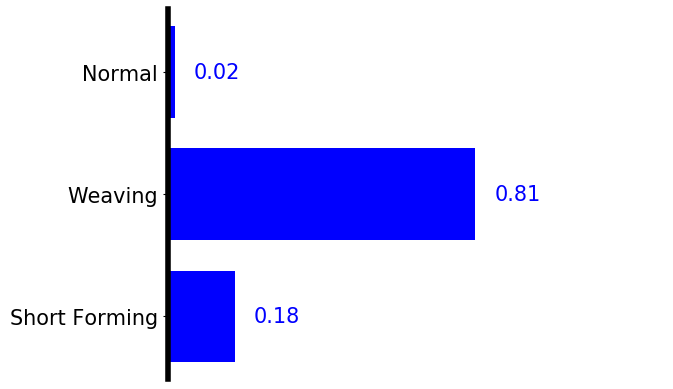

Actual case is Short Forming Case


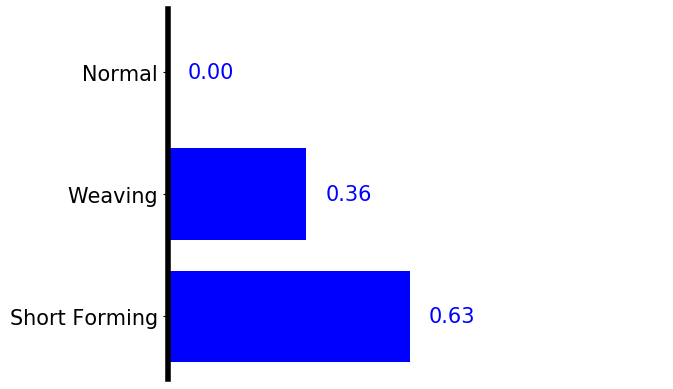

Actual case is Weaving Case


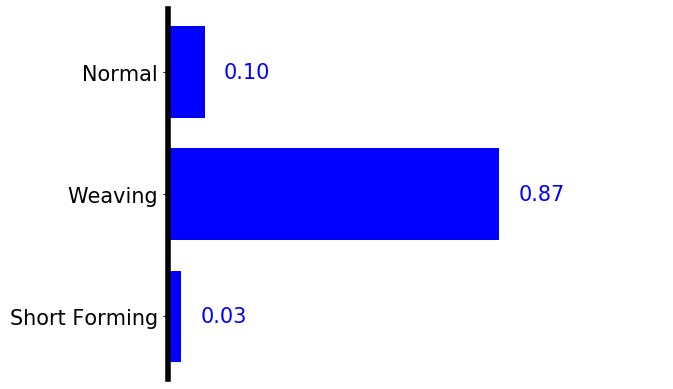

Actual case is Weaving Case


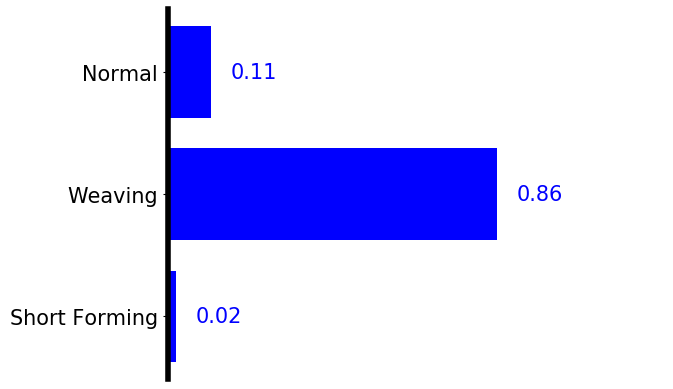

Actual case is Weaving Case


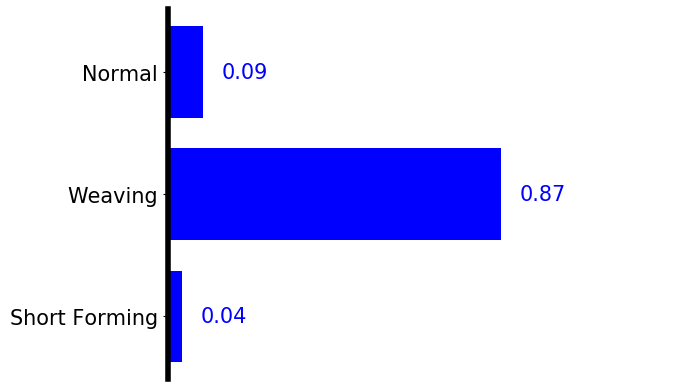

Actual case is Weaving Case


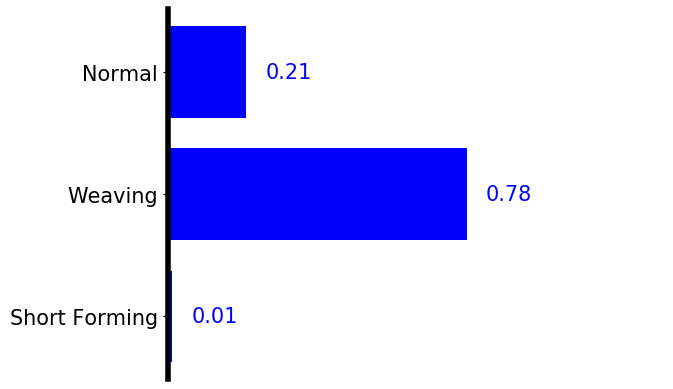

Actual case is Normal Case


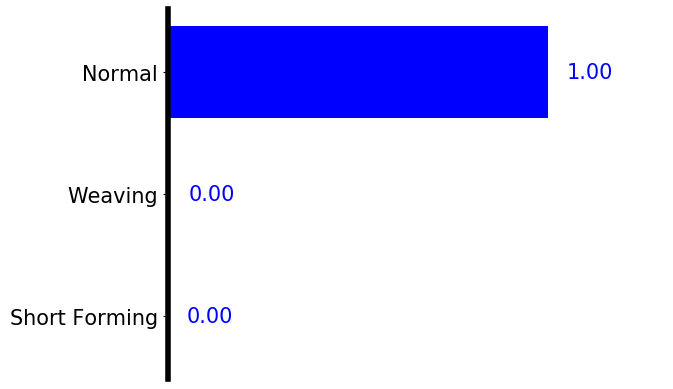

Actual case is Weaving Case


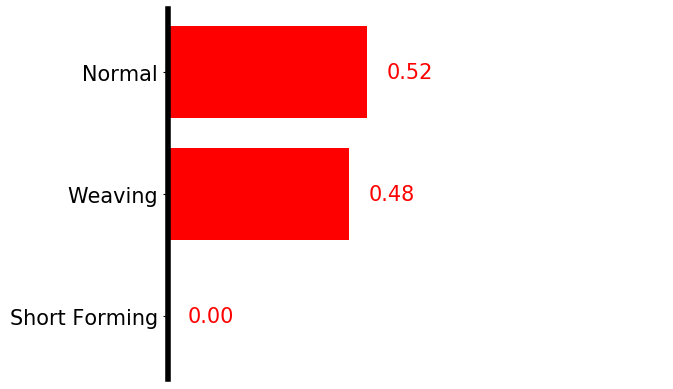

Actual case is Short Forming Case


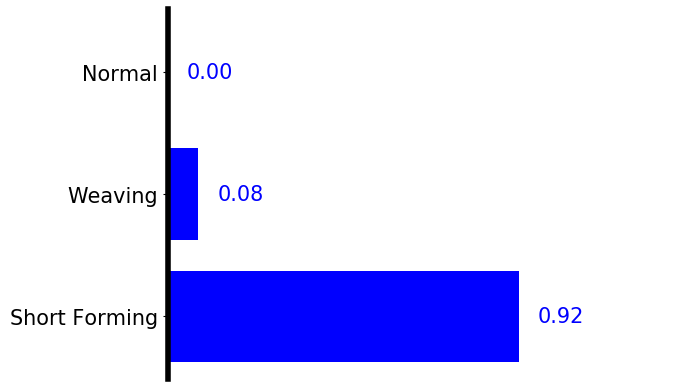

Actual case is Short Forming Case


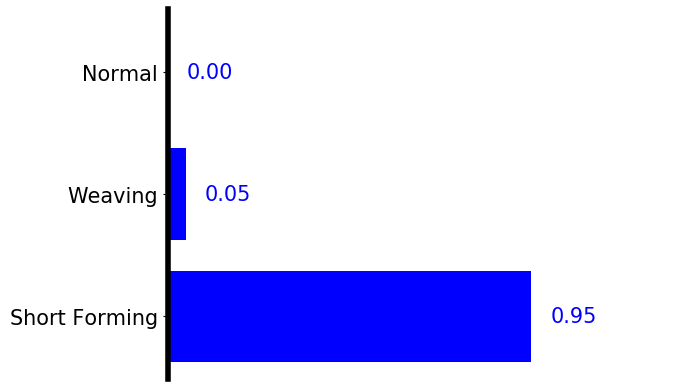

Actual case is Normal Case


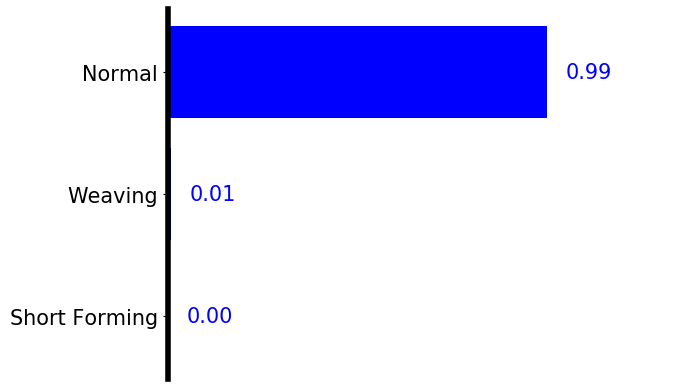

Actual case is Weaving Case


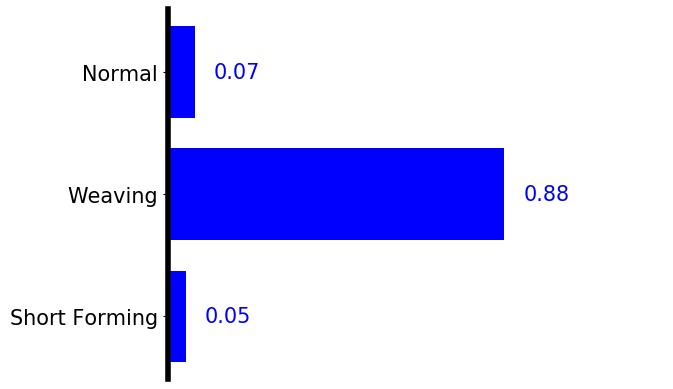

Actual case is Normal Case


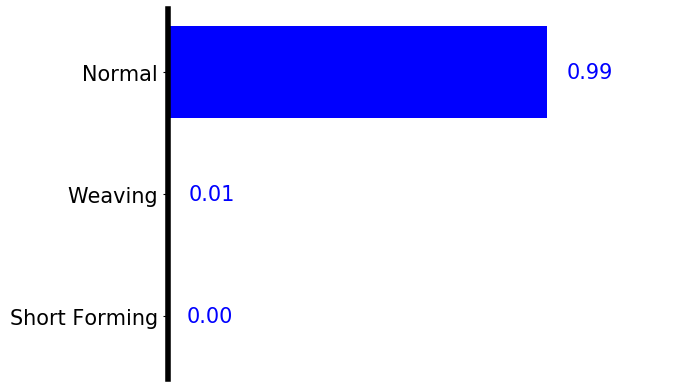

Actual case is Normal Case


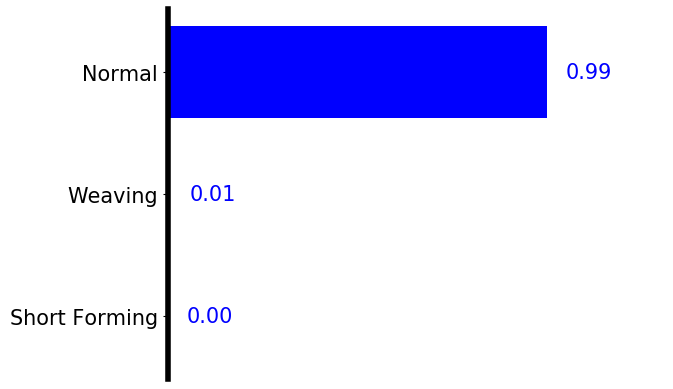

Actual case is Weaving Case


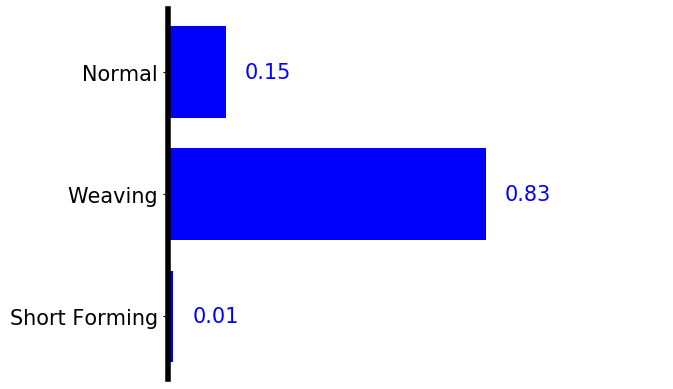

Actual case is Weaving Case


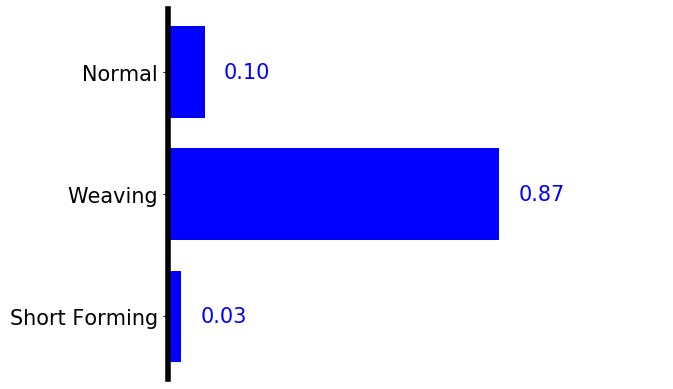

Actual case is Weaving Case


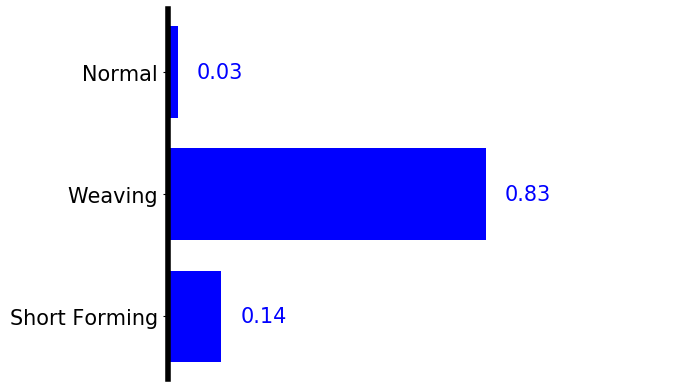

Actual case is Normal Case


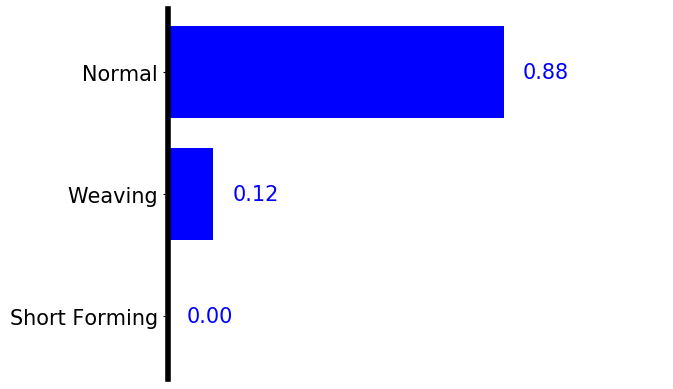

Actual case is Normal Case


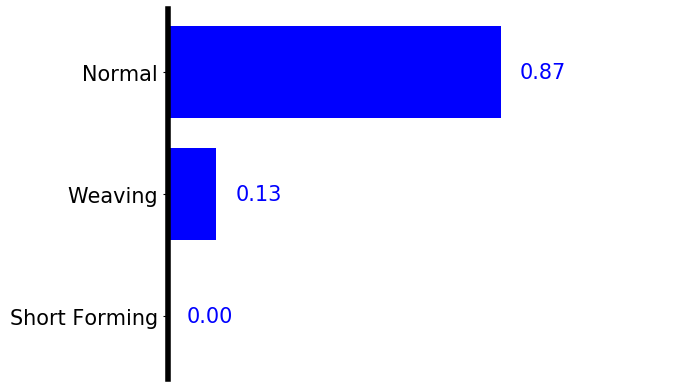

Actual case is Weaving Case


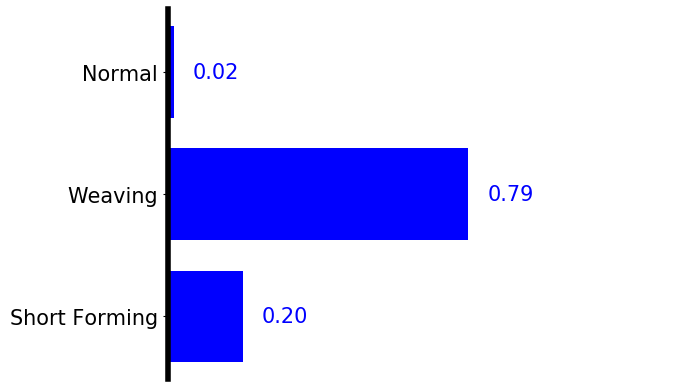

In [12]:
# Run the test as many times as the defined range for visualization of data
for i in range(20):
    # choose a picture at random from the test set that is 30% of the total
    idx=randint(0, 885-1)
    im=test_data[idx]
    actual = test_label[idx]
    if actual == 0:
        print("Actual case is Normal Case")
    elif actual == 1:
        print("Actual case is Weaving Case")
    elif actual == 2:
        print("Actual case is Short Forming Case")

    # feed it to the net and display the confidence scores
    scores =  net( im.view(1,48)) 
    probs= F.softmax(scores, dim=1)
    show_prob_monitoringCase(probs, actual)